# P11 Mouse brains
## Analysis of gene expression, clonality, and location for microglia in mice.
## Version with normalized UMI data, old filtering.

Barcodes were injected into mouse embryos at E9.5.  This notebook carries out analysis at time point P11.  The cells come from two mice and three parts of the brain, coded as follows.

10x39:  animal 1 cortex
10x40:  animal 1 hippocampus
10x41:  animal 1 striatum
10x42:  animal 2 cortex
10x43:  animal 2 hippocampus
10x44:  animal 2 hippocampus

Most of the cells are microglia, and the data contains the expression of about 20000 genes for each cell.  Moreover, barcodes allow us to identify cells belonging to the same clone.  We are interested in whether microglia from one clone are more similar to each other or microglia from one brain area. 

The following are the notebook contents.  Skip step 1, if the data-pickles are already present.

1.  [Preprocessing](#Prep)
2.  [Description and exploration](#Desc)
3.  [Machine learning via linear SVM](#SVM)
4.  [Differential gene expression](#DGE)

<a id='Prep'></a>
## 1. Preprocessing

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

### 1.1 Loading the data

We load the gene expression data and some metadata.  The gene expression data is stored in a large expression matrix, as a CSV file.  The metadata is stored in a separate file.  We load the metadata below, ignoring cells with CloneID zero.  

In [2]:
meta_df = pd.read_csv('P11_datasets/P11_Microglia_metadata.csv', sep=',',
                      index_col=0, header=0, low_memory=False)
meta_df = meta_df[ meta_df['CloneID'] != 0] # Only take cells with known clonotype.
meta_df.CloneID = meta_df.CloneID.apply(str) # Convert clone-labels to strings.

clones = meta_df['CloneID'].unique()
celltypes = meta_df['Celltype'].unique()
areas = meta_df['Area'].unique()
cells = list(meta_df.index)

print('{} single cells found, from {} to {}'.format(len(cells), cells[0], cells[-1]))
print('{} clones found: {}'.format(len(clones), ', '.join(clones)))
print('{} cell types found: {}'.format(len(celltypes), ', '.join(celltypes)))
print('{} areas found: {}'.format(len(areas), ', '.join(areas)))
print('The first five rows of the dataframe are below')
display(meta_df.head())

987 single cells found, from AGTGGGAGTTCCCGAG_1_1 to CGGAGTCAGTCAAGGC_3_2
11 clones found: 337, 156, 587, 203, 138, 352, 4829, 2683, 5110, 3326, 3909
12 cell types found: NIPCs, GABAergicNeurons, AstrocytesGM, OPCs, COPs, Microglia, CRCells, MOLs, exNeurons, VascularEndothelialCells, DGRGLs, PerivascularMacrophages
3 areas found: cx, hc, str
The first five rows of the dataframe are below


,CloneID,Celltype,Area,Clonesize
AGTGGGAGTTCCCGAG_1_1,337,NIPCs,cx,726.0
ATCTACTCACACCGCA_1_1,337,NIPCs,cx,726.0
GTATTCTTCCGTTGCT_1_1,337,NIPCs,cx,726.0
GTGCAGCAGAGTTGGC_1_1,337,NIPCs,cx,726.0
TTGCGTCAGGGTATCG_1_1,337,NIPCs,cx,726.0


In [3]:
cells = meta_df.index[meta_df['Celltype'] == 'Microglia'].tolist() # Restrict to Microglia
print('{} microglia found'.format(len(cells)))

942 microglia found


The expression matrix is pretty big.  We will load the whole thing, then extract the data for the (roughly 1000) cells of interest.

In [4]:
EM_filepath = 'P11_datasets/P11_EM_normalized.csv' # Change as needed.

EM_df = pd.read_csv(EM_filepath, sep=',',index_col=0, header=0, low_memory=False)

In [5]:
EM_df = EM_df[cells] # We only care about the cells with known clonotype.
EM_df = EM_df.transpose() # Cells as rows, genes as columns now.
EM_df.head()

,Xkr4,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,St18,...,Foxd4,I830134H01Rik,Nkx2-3,Sec31b,4930505N22Rik,Pitx3,Vwa2,Gm16277,AC132444.6,Vmn2r122
AAACCTGAGCGATGAC_1_1,0.0,0.0,1.794055,0.0,1.254731,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCAGGCGATA_1_1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGTCCGAGCCA_1_1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGCATGAAGTA_1_1,0.0,0.0,0.000000,0.0,1.597073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGGTAAAGTCA_1_1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
EM_df.to_pickle('P11_EM_full.pkl') # Save file as a pickle.
meta_df.to_pickle('P11_meta.pkl') # Pickle the metadata too.

### 1.2.  Munging data

Now we preprocess the data for downstream use.

In [7]:
EM_raw = pd.read_pickle('P11_EM_full.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle('P11_meta.pkl') # Load metadata from a pickle.

In [8]:
genes = list(EM_raw.columns)  # The names of the genes. 
cells = list(EM_raw.index) # The names of the cells.
clones = meta_df['CloneID'].unique()
areas = meta_df['Area'].unique()

We filter genes, to only include genes that are expressed above a threshold, in a certain percentage of cells.  We also provide the option to exclude genes from a supplied list, if necessary.

In [9]:
def get_relevant(gf, eg = [], prevalence=0.05, threshold = 0):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    0 or above.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [10]:
genes_relevant = get_relevant(EM_raw)

In [11]:
print("{} Microglia cells are included, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), 
                                                                genes_relevant[0], genes_relevant[-1]))

942 Microglia cells are included, from AAACCTGAGCGATGAC_1_1 to TTTACTGCACCTGGTG_2_2.
18148 genes are measured, from Xkr4 to Vmn2r122.
5673 genes are considered relevant, from Mrpl15 to chrH2B-EGFP-N.


Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [12]:
def nGene(ge, md, cutoff = 0, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed > 0.
    nG.name = 'num_genes'
    clonalities = md.CloneID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="CloneID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="CloneID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

//anaconda/envs/Genomics/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


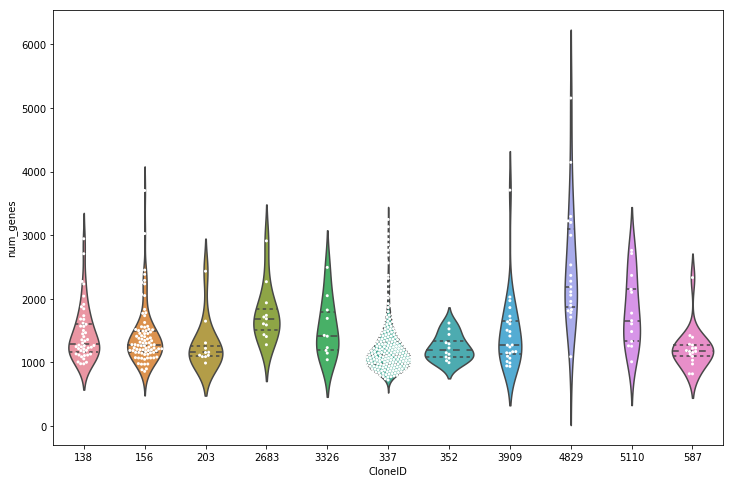

In [15]:
nG = nGene(EM_raw, meta_df)

Now we pick out the "good cells", whose expressed-gene-number is within 50% of the mean (within each clone).

In [16]:
within = 0.5 # Stay within within of the mean.

nG_std = nG.groupby('CloneID').apply(np.std)
nG_means = nG.groupby('CloneID').apply(np.mean)
nG_lowcut = (nG_means* (1 - within)).num_genes
nG_highcut = (nG_means* (1 + within)).num_genes
cells_good = [c for c in cells if 
              (nG.num_genes[c] >= nG_lowcut[nG.CloneID[c]]) and 
              (nG.num_genes[c] <= nG_highcut[nG.CloneID[c]]) 
             ]
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

884 cells remaining after 58 poor libraries removed.


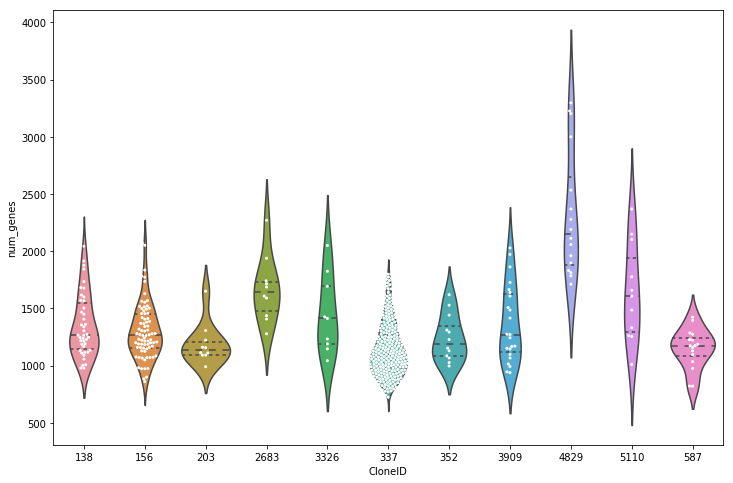

In [17]:
nG = nGene(EM_raw.loc[cells_good], meta_df.loc[cells_good]) # Post-trimming violin-plot.

We should keep an eye on CloneID 4829... to make sure that results are not due to the large number of genes expressed.

Now we clip our data, declaring all expressions below zero (or a threshold) to be dropouts.

In [18]:
EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
EM = EM.loc[cells_good] # Only use good cells.
EM.clip_lower(0, inplace = True) # Clip any negative values to zero.
EM.dropna(inplace = True) # Get rid of all rows with NaNs too.

With our preprocessing complete, we pickle the data for later.

In [19]:
EM.to_pickle('P11_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (884, 5673)


<a id='Desc'></a>
## 2.  Description and exploration

Start here if the data has already been preprocessed!

We explore the data a bit more closely, before tackling the serious questions. We begin by loading and reviewing the data from pickles.

In [20]:
EM = pd.read_pickle('P11_EM.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle('P11_meta.pkl') # Load metadata from a pickle.

genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.
meta_df = meta_df.loc[cells] # Only include relevant cells in meta_df hereafter.

clones = meta_df['CloneID'].unique()
areas = meta_df['Area'].unique()

print("{} Microglia cells are loaded, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} genes are loaded, from {} to {}.".format(len(genes),genes[0],genes[-1]))
print("The cells belong to {} clones: {}.".format(len(clones),', '.join(clones)))
print("The cells come from {} areas: {}.".format(len(areas),', '.join(areas)))

884 Microglia cells are loaded, from AAACCTGAGCGATGAC_1_1 to TTTACTGCACCTGGTG_2_2.
5673 genes are loaded, from Mrpl15 to chrH2B-EGFP-N.
The cells belong to 11 clones: 337, 156, 587, 203, 138, 352, 4829, 2683, 5110, 3909, 3326.
The cells come from 3 areas: cx, hc, str.


### 2.1.  Cell demographics

We examine the metadata more closely, and tabulate the populations of the clones and within each area.  The areas are denoted cx (cortex), hc (hippocampus), and str (striatum).

In [21]:
pop_table = pd.DataFrame(index = list(clones)+['total'], columns = list(areas)+['total'] )
for clone in clones:
    for area in areas:
        ca_pop = len(meta_df[ (meta_df['CloneID'] == clone) & (meta_df['Area'] == area)])
        pop_table.loc[clone, area] = ca_pop

for clone in clones:
    pop_table.loc[clone, 'total'] = len(meta_df[ (meta_df['CloneID'] == clone)])

for area in areas:
    pop_table.loc['total', area] = len(meta_df[ (meta_df['Area'] == area)])

print('The following table gives the number of cells within each clone and area.')
display(pop_table)

The following table gives the number of cells within each clone and area.


,cx,hc,str,total
337,637,2,19,658
156,1,76,0,77
587,8,8,0,16
203,2,8,0,10
138,0,42,0,42
352,0,12,0,12
4829,16,0,0,16
2683,9,1,0,10
5110,11,0,0,11
3909,0,23,0,23


Most of the clones are associated with a specific area.  Only the large clone 337 has any cells in the striatum (*str*).  Clone 156 is primarily found in the hippocampus.  Clone 4829 is only found in the cortex.  But clone 587 is evenly divided between the cortex and hippocampus.

This close relationship between clonality and area means that we will have to be careful to disentangle whether gene expression depends on clonality or on area.  For now, we use the table above to re-order our clones so that clones from the same area are adjacent in the list.

In [22]:
clones = ['337', '4829', '5110', '2683', '587', '203', '3326', '352', '3909', '156', '138']
pop_table = pop_table.reindex(clones + ['total'])
display(pop_table) # Nicer order now.

,cx,hc,str,total
337,637,2,19,658
4829,16,0,0,16
5110,11,0,0,11
2683,9,1,0,10
587,8,8,0,16
203,2,8,0,10
3326,0,9,0,9
352,0,12,0,12
3909,0,23,0,23
156,1,76,0,77


To dodge problems with imbalanced data (which can cause classifier bias), we may avoid the largest clones:  337, 156, and 138.  Later we will tackle imbalanced data by random subsampling.

In [23]:
clones_sm = [clone for clone in clones if clone not in ['337', '156', '138']]
cells_sm = [cell for cell in cells if meta_df.loc[cell, 'CloneID'] in clones_sm]
print('{} cells belong to small clones.'.format(len(cells_sm)))

107 cells belong to small clones.


### 2.2.  Gene examination and dropouts

We examine the gene expressions a bit more closely now.  We begin with a table of descriptive statistics for each gene.

In [24]:
EM.describe()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Sgk3,Snhg6,...,Rab11fip2,Fam204a,Eif3a,Fam45a,Prdx3,Csf2ra,Vamp7,PISD,DHRSX,chrH2B-EGFP-N
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,...,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,0.178017,0.155879,0.246845,0.113846,0.155881,0.141757,0.127274,0.134611,0.159241,0.158842,...,0.141609,0.268787,0.544991,0.158346,0.314260,0.281985,0.102291,0.395805,0.148763,3.621063
std,0.485950,0.462757,0.583362,0.398208,0.471354,0.456013,0.424948,0.442979,0.477451,0.469807,...,0.459744,0.594577,0.786189,0.475081,0.637973,0.624040,0.378541,0.721329,0.465577,0.802308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.278340
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.083438
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.893268
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.396187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.251628
max,2.529509,2.375030,2.493614,2.303891,2.580223,2.360564,2.317388,2.293812,2.087180,2.193323,...,2.670062,2.577596,2.764772,2.318213,2.439362,2.784861,1.909606,2.900115,2.287824,4.936263


Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above zero).  The *mean nonzero* is the mean of the expression of the gene, restricting to the nonzero expressions.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.

In [25]:
def dropmean(df):
    no_cells = len(df)
    max_expression = df.max()
    dropout_df = df.apply(lambda column: ((column > 0.0).sum()) / no_cells )
    meannz_df = df.apply(lambda column: column.replace(0, np.nan).mean()) # Use NaN to exclude from mean computation.
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

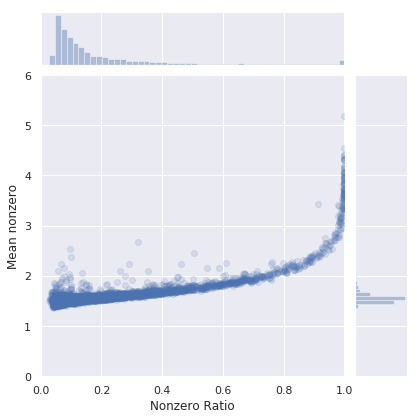

In [27]:
dm_df = dropmean(EM) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,6), height=6)

I hadn't worked with UMI data before, but this curve is really tight!  I like it.  It was also pretty tight for the raw (unnormalied) UMI data, but I thought a bit of normalization would help.  Note that I have *not* used the batch-adjusted data.

<a id='SVM'></a>
## 3.  Machine learning via linear SVM

To what extent is gene expression correlated, or even predictive, of clonality?  Of the area in which a cell is found?  We take a supervised machine learning approach to these question, training the computer to predict clonality and area from gene expression.

First we load a large number of scikit-learn packages.

In [28]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
from statsmodels.formula.api import ols
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE # In case we want to cluster.

On our first pass, we consider just the small clones to avoid class imbalance.  Note that clone 337 is huge (10-50 times as big) compared to the other clones.  There is a related imbalance towards cells of the cortex.  See [the book chapter by Batuwita and Palade](http://www.cs.ox.ac.uk/people/vasile.palade/papers/Class-Imbalance-SVM.pdf) for a survey of techniques for applying support vector machines in imbalanced data. We avoid it for now.

We set up our feature matrix `X` (gene expressions) and classes (clones) `y` below.

In [29]:
X = EM.loc[cells_sm] # Include only the small clones.
X_cells = X.index
y = meta_df.loc[X_cells].CloneID

### 3.2.  General-purpose functions

The following functions will be used to visualize the results of the machine learning algorithms.

In [30]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [31]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None, proportion = True):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    if proportion:
        valid = counts.apply(lambda column : column/cpops['pop'])
    else:
        valid = counts
    
    f, ax = plt.subplots(figsize=(8,7))
    if proportion:
        fmt = '2.0%'
    else:
        fmt = 'd'
    sns.heatmap(valid, annot=valid, square=True, fmt=fmt, linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    if proportion:
        cbar.set_ticks([0, .25, .5, .75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [32]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [33]:
def vis_genebars(ef, mf, genelist, prop, classlist = None,z_score=True, binarize=False, 
                 cutoff = 1.0, num_genes = False, sort=True, genelabels = True, fitlabels = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        num_genes:  Plot an extra row, for the total number of genes expressed.
        sort:  If True, sort and hierarchically cluster the genes.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > 0.0).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    df[prop] = mf[prop]
    if classlist:
        df = sort_by(df, prop, classlist)
    else:
        df.sort_values(prop, inplace=True)
    
    cells = df.index
    md = mf.loc[cells]
    if classlist:
        classes = classlist
    else:
        classes = md[prop].unique()

    # Create plot.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    fig, axes = plt.subplots(2,1, sharex = True, figsize=(12, figheight), 
                             gridspec_kw = {'height_ratios':[0.25, 11.75], 'hspace':0.005})
    
    
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    evenpal = pal[1::2]
    pal[1::2] = evenpal[::-1] # Make palette zebra-striped to distinguish adjacent classes.
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    div_pal = sns.diverging_palette(220, 20, n=25)
    
    # Resort genes, based on hierarchical clustering and distance.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'
    if sort:
        Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
        genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]
    else:
        genelist_sort = genelist
        
    if num_genes:
        genelist_sort = ['num_genes'] + genelist_sort 
    
    if binarize:
        sns.heatmap(df[genelist_sort].transpose(), cmap='magma', ax=axes[1], cbar = None)
    elif zscore:
        sns.heatmap(df[genelist_sort].transpose(), vmin=-3, vmax=3, cmap = div_pal, ax=axes[1], 
                    cbar_kws={"orientation": "horizontal", "fraction":0.025, "pad":0.025})
    

    axes[0].vlines(cells,0,0.05, colors = colors, 
                   linewidth = 72*12 / len(cells), 
                   offsets = (72*6 / len(cells), 0))

    for c in classes:
        mdp = md[md[prop] == c]
        midcell = mdp.index[len(mdp) // 2]
        axes[0].text(midcell, 0.065, c, horizontalalignment='center')

    axes[0].axis('off')
    axes[0].grid(False)

    axes[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    if genelabels:
        axes[1].tick_params(axis='y', rotation=0)
    else:
        axes[1].yaxis.set_ticklabels([])

    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    if binarize:
        title.append('Binarized gene expression.')
    elif z_score:
        title.append('Color represents z-score.')
    fig.suptitle('\n '.join(title))
    plt.show()

### 3.3.  Linear SVM.

In [34]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=100)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=1000)) ])

param_grid = dict(skb__k = [2,5,10,50,100,150,200,250], svm__C = [0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=4, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=100, score_func=<function f_classif at 0x1a1fdfe1e0>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': [2, 5, 10, 50, 100, 150, 200, 250], 'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

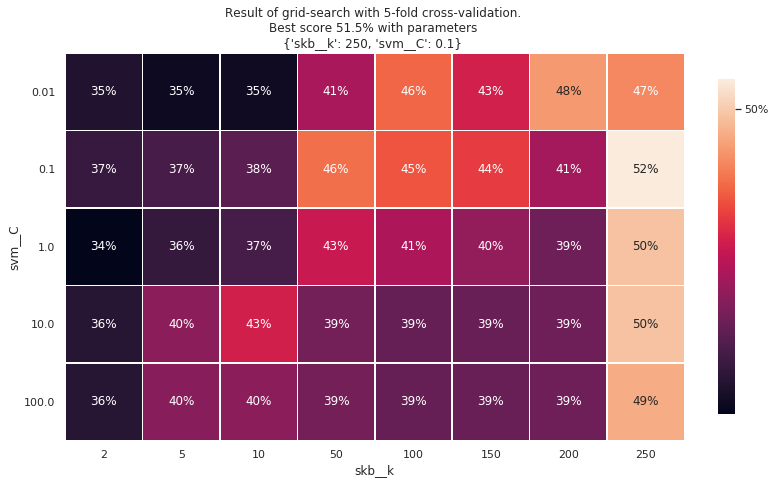

In [35]:
CV_map(grid_search, swap=True)

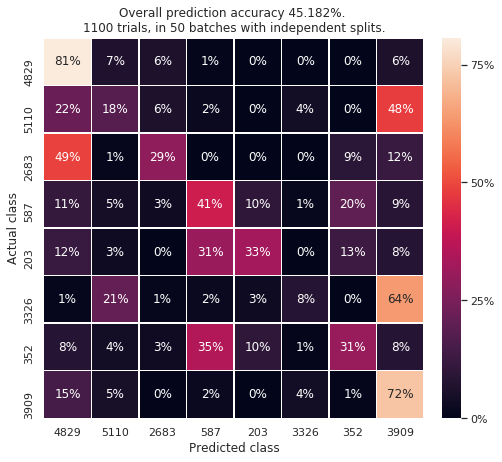

In [36]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

confusion_matrix(X,y,SVM_pipe, reps=50, classlist = clones_sm)

The classifier is nowhere near perfect -- there are a lot of misclassifications -- but it's better than one would expect by chance.  There is some classifier bias evident in the confusion table as well.  Clones 3909 and 587 and 4829 are bigger than the other clones, and they tend to "attract predictions" because of this.  We will handle this imbalance in a more robust manner in the next section.

In [38]:
pop_table.loc[clones_sm] # See the imbalance below!

,cx,hc,str,total
4829,16,0,0,16
5110,11,0,0,11
2683,9,1,0,10
587,8,8,0,16
203,2,8,0,10
3326,0,9,0,9
352,0,12,0,12
3909,0,23,0,23


The support vector machine operates by first normalizing all gene expressions to be between 0 and 1.  Then it selects the top genes by ANOVA F-statistic, for distinguishing clones.  Here we study the top bunch of genes, when the SVM is run on the entire training set (all cells from small clones).

In [39]:
SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: Ier5, Atf3, Rpl12, Rpl35, Snap25, Rps21, Pcsk1n, Rpl39, Tsix, Xist, Bex2, Fcgr1, Rps20, Chmp5, Wasf2, Camk2n1, Rpl28, Ftl1, Ppp1r15a, Gdpd3, Rplp2, Tnni2, Rps12, Smpd2, Tmpo, Atp5b, Klf2, Ier2, Lcp1, Tpt1, Rplp1, Ccrl2, Plek, Sptbn1, Irf1, Mmgt2, Cd83, Atg10, Nfkbia, Sepp1, Nr4a1, Rps10, Tnf, Ier3, Abcf1, Mrps18a, Erdr1, Fth1, Zfand5, chrH2B-EGFP-N


To see how these genes distinguish clones, we visualize their expression levels below.  Note that the first three clones (4829, 5110, 2683) are almost always found in the cortex, while the last four clones (203, 3326, 352, 3909) are almost always found in the hippocampus.  Clone 587 is found half of the time in the cortex and half of the time in the hippocampus.

One can see that a few genes seem to distinguish area:  Fam178b and Rims4 seem turned off in the cortex but frequently active in the hippocampus.  

Within the areas, some clones seem distinguished by gene expression as well.  For example, Cd83 seems turned off for 5110 clones but on for other clones in the cortex like 2683.  Xist is off for 3326 clones, while but on for most 352 clones.  In this way, Xist separates two clones within the hippocampus.

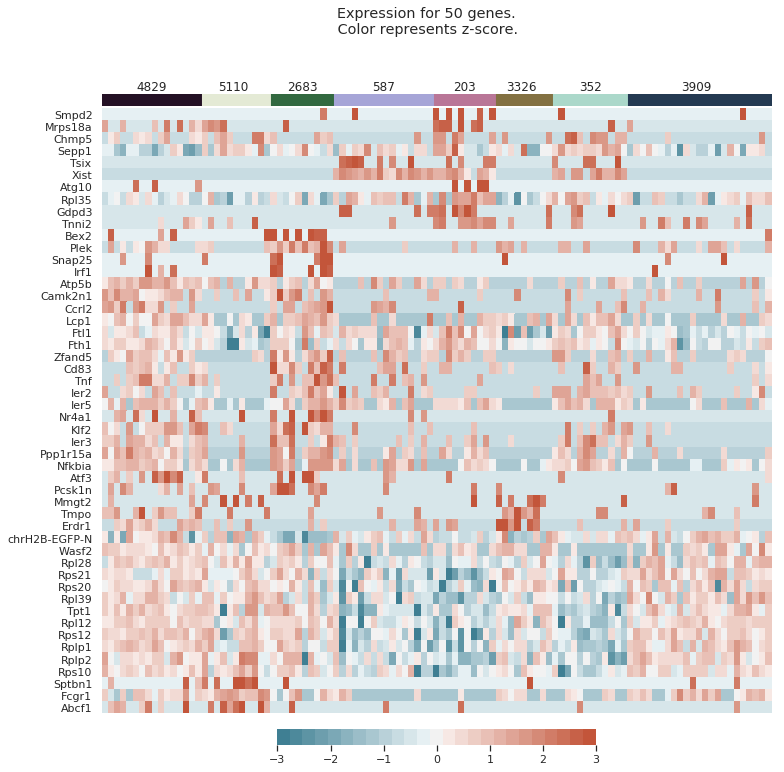

In [41]:
vis_genebars(X, meta_df, diff_genes, 'CloneID', classlist = clones_sm, genelabels = True, fitlabels = True)

### 3.4:  Machine learning with imbalanced data.

We use the [imbalanced-learn Python package](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html) to carry out undersampling of data.  In most machine learning applications, one would operate only on training data.  But here we randomly undersample the *entire* data set, basically pretending that our data is evenly distributed between clones.  For in the end, we are not interested in maximizing predictive accuracy -- in our highly imbalanced setting, that's best accomplished by simply choosing the massive clone all the time.  Instead, we wish to differentiate the clones as if they were evenly sized.

In [76]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as IPipeline

In [99]:
X = EM.loc[cells] # Include all the clones.
X_cells = X.index
y = meta_df.loc[X_cells].CloneID

In [100]:
us = RandomUnderSampler()
X_res, y_res = us.fit_resample(X, y)
np.unique(y_res, return_counts=True)

(array(['138', '156', '203', '2683', '3326', '337', '352', '3909', '4829',
        '5110', '587'], dtype=object),
 array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]))

All clones have been randomly undersampled so they have the same number of cells as the smallest clone.  With small clones like this, we limit our cross-validation to 4 folds.  The lines below create dataframes from the undersampled data.

In [101]:
cells_sub = X.index[us.sample_indices_]
X_res = X.loc[cells_sub]
y_res = y.loc[cells_sub]

In [114]:
##  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=100)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=1000)) ])

param_grid = dict(skb__k = [5,10,25,50,75,100,150,200], svm__C = [0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=4, iid=False) #4-fold cross-validation.
grid_search.fit(X_res,y_res)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=100, score_func=<function f_classif at 0x1a1fdfe1e0>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': [5, 10, 25, 50, 75, 100, 150, 200], 'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

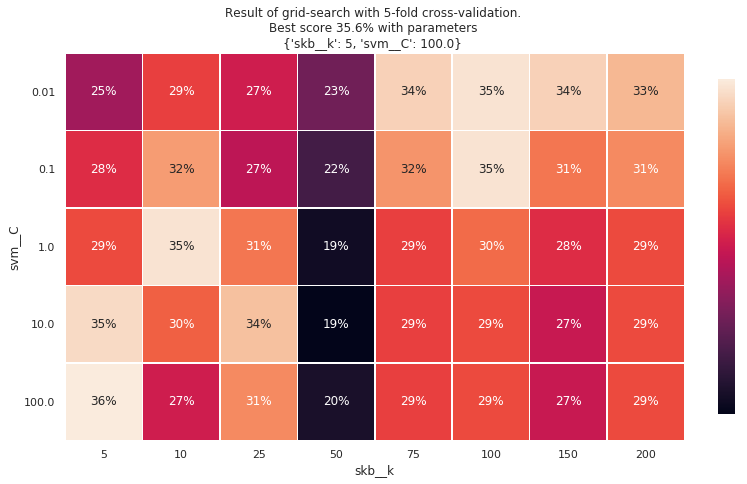

In [115]:
CV_map(grid_search, swap=True)

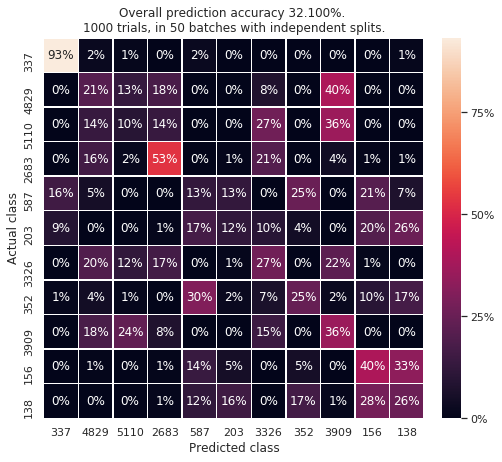

In [117]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

confusion_matrix(X_res,y_res,SVM_pipe, reps=50, classlist = clones)

In [118]:
display(pop_table)

,cx,hc,str,total
337,637,2,19,658
4829,16,0,0,16
5110,11,0,0,11
2683,9,1,0,10
587,8,8,0,16
203,2,8,0,10
3326,0,9,0,9
352,0,12,0,12
3909,0,23,0,23
156,1,76,0,77


In [119]:
SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=5)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

SVM_pipe.fit(X_res,y_res)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

The 5 differentially expressed genes (selected by ANOVA F) are: Rps21, Rpl39, Xist, Rps12, chrH2B-EGFP-N


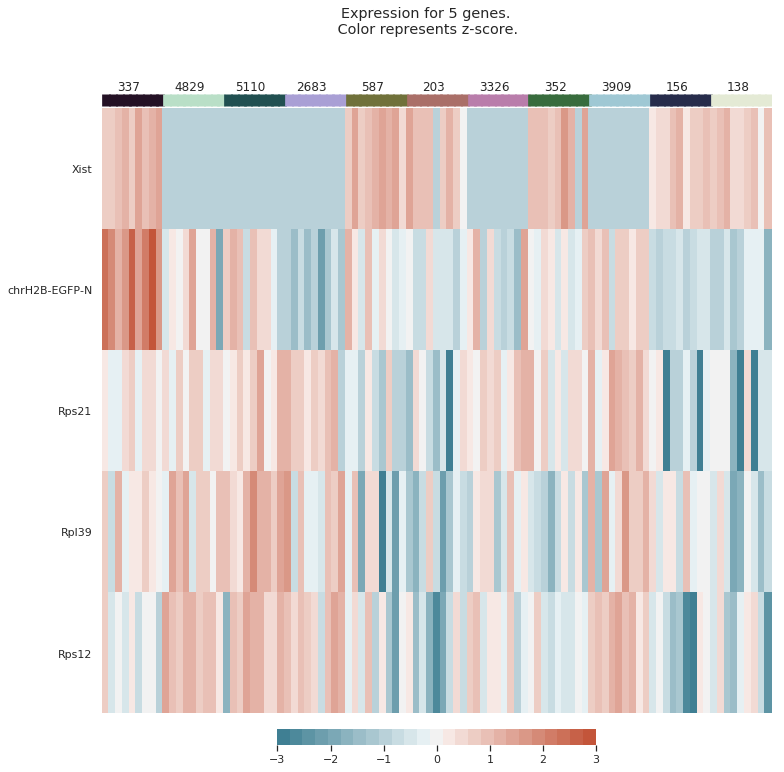

In [121]:
vis_genebars(X_res, meta_df, diff_genes, 'CloneID', classlist = clones) #, genelabels = True, fitlabels = True)

Is it just me, or are your 337-clones glowing green ;)  Is the clear pattern in Xist something that's understood already?  There are a lot of Rps and Rpl genes with significant F-statistic.  I'm not sure what to make of those.

In [122]:
SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

SVM_pipe.fit(X_res,y_res)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: Ier5, Rpl12, Dusp2, Rps21, Rpl39, Xist, Lxn, Fcgr1, Cisd2, Rps20, Chmp5, Btf3l4, Gm13251, Tmem175, Ccz1, Rpia, Psenen, Ftl1, Ppp1r15a, Rps13, Gde1, Gdpd3, Rplp2, Rps12, Smpd2, Oaz1, Atp5b, Klf2, Ier2, Rps24, Tpt1, Rplp1, Smarcc1, Plek, Irf1, Brd9, Nfkbia, Rpl30, Klf10, Rpl3, Liph, Hes1, Rps10, Taf11, Pim1, Tnf, Calm2, Erdr1, Taf6l, chrH2B-EGFP-N


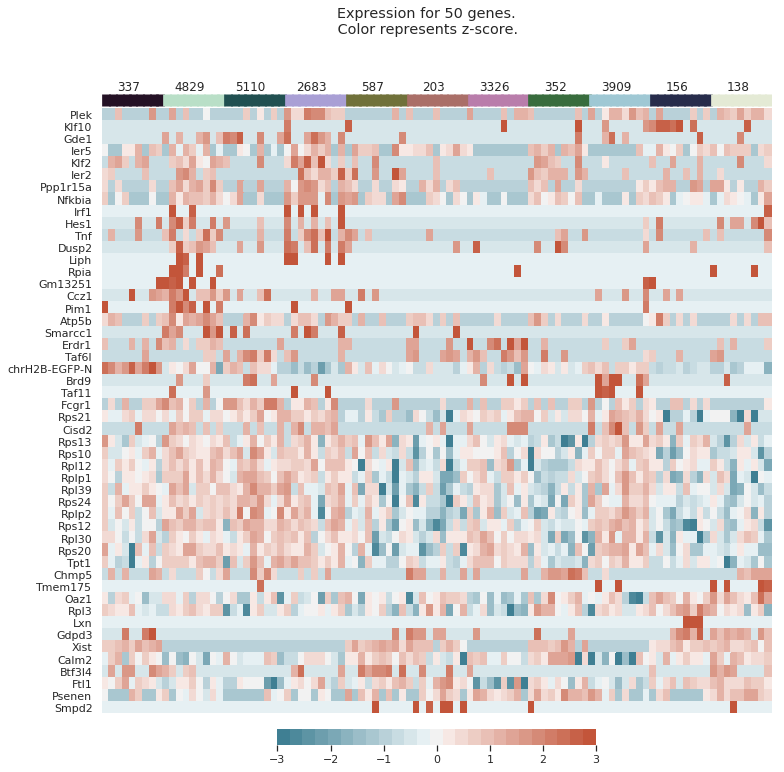

In [123]:
vis_genebars(X_res, meta_df, diff_genes, 'CloneID', classlist = clones) #, genelabels = True, fitlabels = True)

<a id='DGE'></a>
## 4.  Differential gene expression